In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
# ----------------------------------
# Physical and numerical parameters
# ----------------------------------
L = 10e6             # Domain length in y-direction (meters)
ny = 201             # Number of grid points
dy = L / (ny - 1)    # Grid spacing
y = np.linspace(-L/2, L/2, ny)

T = 2 * 24 * 3600    # Total simulation time (2 days)
nt = 2000            # Number of time steps
dt = T / nt          # Time step size

g = 9.81             # Gravitational acceleration (m/s²)
H = 10000            # Mean fluid depth (m)
beta = 2.3e-11       # Equatorial beta (1/(m·s))

In [3]:
# ------------------------
# Initial Conditions
# ------------------------
def initial_conditions():
    sigma = 1e6
    phi = y * np.exp(-y**2 / (2 * sigma**2))  # geopotential anomaly (eta)
    u = phi.copy()                             # zonal velocity proportional to phi
    v = np.gradient(phi, dy)                   # meridional velocity as d(phi)/dy
    return u, v, phi


In [4]:
# ------------------------
# Finite difference schemes
# ------------------------
@njit
def derivative(arr, dy, scheme='centered'):
    d = np.zeros_like(arr)
    if scheme == 'forward':
        d[:-1] = (arr[1:] - arr[:-1]) / dy
        d[-1] = d[-2]
    elif scheme == 'backward':
        d[1:] = (arr[1:] - arr[:-1]) / dy
        d[0] = d[1]
    elif scheme == 'centered':
        d[1:-1] = (arr[2:] - arr[:-2]) / (2 * dy)
        d[0] = d[1]
        d[-1] = d[-2]
    return d


In [5]:
# ------------------------
# One time step (Euler)
# ------------------------
@njit
def step_matsuno(u, v, eta, dy, dt, scheme):
    du_dt = -g * derivative(eta, dy, scheme)
    dv_dt = -g * beta * y * eta
    deta_dt = -H * derivative(v, dy, scheme)

    u_new = u + dt * du_dt
    v_new = v + dt * dv_dt
    eta_new = eta + dt * deta_dt

    return u_new, v_new, eta_new

In [6]:
# ------------------------
# Run the model
# ------------------------
def run_model(scheme='backward'):
    u, v, eta = initial_conditions()
    u_hist, v_hist, eta_hist = [u.copy()], [v.copy()], [eta.copy()]  # Store u, v, eta
    
    for _ in range(nt):
        u, v, eta = step_matsuno(u, v, eta, dy, dt, scheme)
        u_hist.append(u.copy())
        v_hist.append(v.copy())
        eta_hist.append(eta.copy())
    
    return np.array(u_hist), np.array(v_hist), np.array(eta_hist)

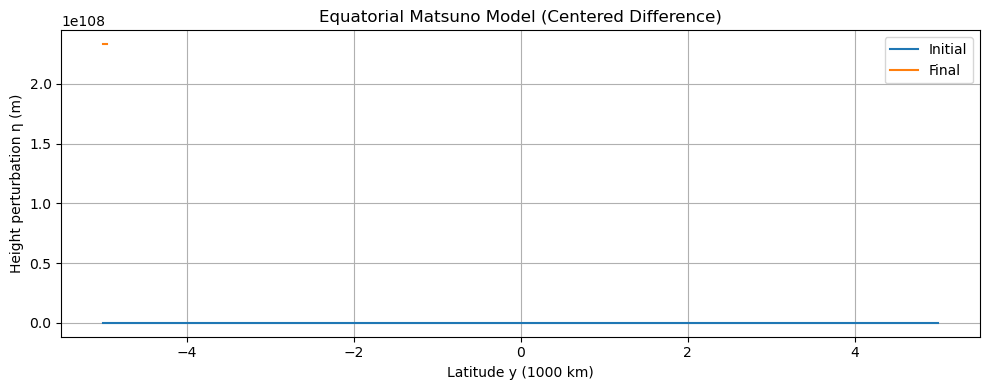

In [9]:
# ------------------------
# Run and visualize
# ------------------------
u_hist, v_hist, eta_hist = run_model(scheme='backward')

# Plot initial and final height fields
plt.figure(figsize=(10, 4))
plt.plot(y/1e6, eta_hist[0], label='Initial')
plt.plot(y/1e6, eta_hist[-1], label='Final')
plt.xlabel('Latitude y (1000 km)')
plt.ylabel('Height perturbation η (m)')
plt.title('Equatorial Matsuno Model (Centered Difference)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

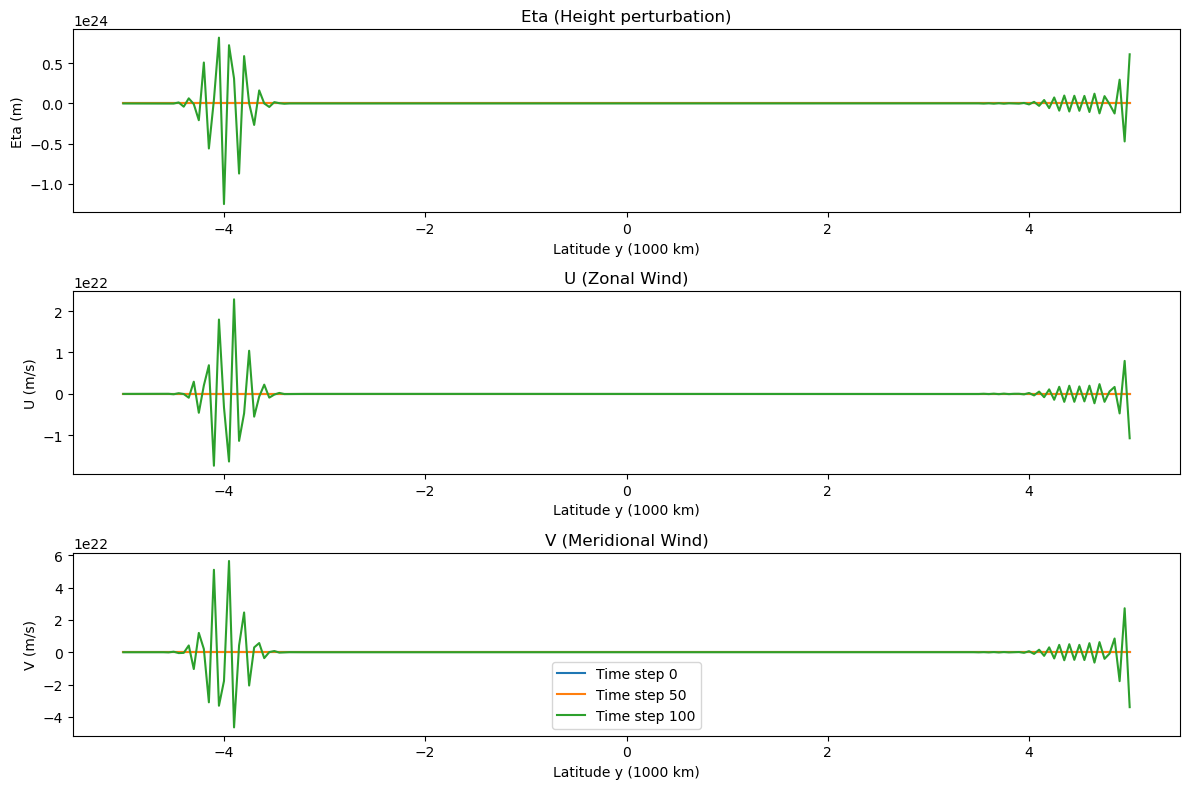

In [22]:
import matplotlib.pyplot as plt

def plot_horizontal_structure(u_hist, v_hist, eta_hist, times_to_plot=[0, 50, 100]):
    """Plot the horizontal structure (u, v, eta) at different time steps"""
    plt.figure(figsize=(12, 8))
    
    # Select the time steps you want to plot
    for time_step in times_to_plot:
        # Plot eta (height perturbation)
        plt.subplot(3, 1, 1)
        plt.plot(y / 1e6, eta_hist[time_step], label=f'Time step {time_step}')
        plt.title('Eta (Height perturbation)')
        plt.xlabel('Latitude y (1000 km)')
        plt.ylabel('Eta (m)')
        
        # Plot u (zonal wind)
        plt.subplot(3, 1, 2)
        plt.plot(y / 1e6, u_hist[time_step], label=f'Time step {time_step}')
        plt.title('U (Zonal Wind)')
        plt.xlabel('Latitude y (1000 km)')
        plt.ylabel('U (m/s)')
        
        # Plot v (meridional wind)
        plt.subplot(3, 1, 3)
        plt.plot(y / 1e6, v_hist[time_step], label=f'Time step {time_step}')
        plt.title('V (Meridional Wind)')
        plt.xlabel('Latitude y (1000 km)')
        plt.ylabel('V (m/s)')
    
    plt.tight_layout()
    plt.legend()
    plt.show()

# Example usage: Plot the horizontal structure at time steps 0, 50, and 100
plot_horizontal_structure(u_hist, v_hist, eta_hist, times_to_plot=[0, 50, 100])

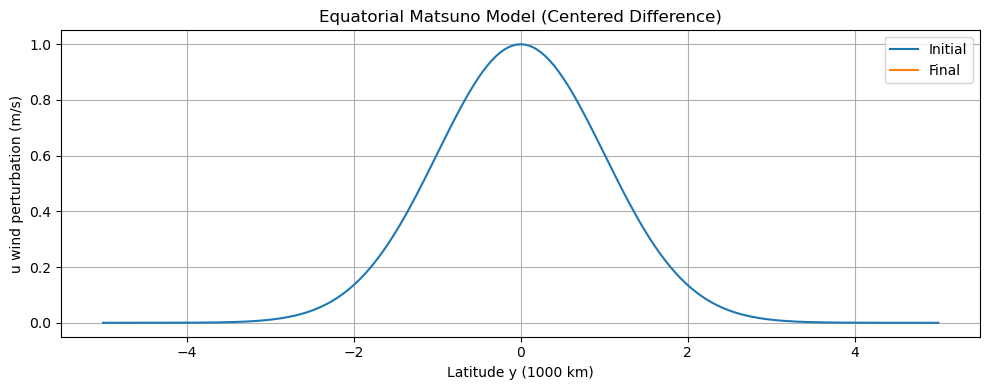

In [10]:
# ------------------------
# Run and visualize
# ------------------------
v_hist = run_model(scheme='centered')

# Plot initial and final height fields
plt.figure(figsize=(10, 4))
plt.plot(y/1e6, v_hist[0], label='Initial')
plt.plot(y/1e6, v_hist[-1], label='Final')
plt.xlabel('Latitude y (1000 km)')
plt.ylabel('v wind perturbation (m/s)')
plt.title('Equatorial Matsuno Model (Centered Difference)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

TypeError: Input z must be 2D, not 1D

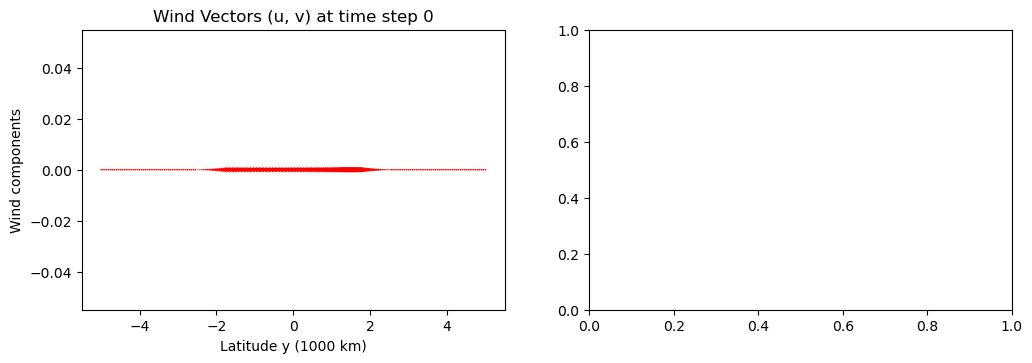

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_horizontal_structure_wind_and_eta(u_hist, v_hist, eta_hist, times_to_plot=[0, 50, 100]):
    """
    Plot the horizontal structure of wind components (u, v) and height perturbation (eta) as contours.
    """
    plt.figure(figsize=(12, 8))
    
    for time_step in times_to_plot:
        # Plot Wind (u, v) using quiver plot
        plt.subplot(2, 2, 1)
        plt.quiver(y / 1e6, np.zeros_like(y), u_hist[time_step], v_hist[time_step], 
                   scale=10, color='r', label=f'Time step {time_step}')
        plt.title(f'Wind Vectors (u, v) at time step {time_step}')
        plt.xlabel('Latitude y (1000 km)')
        plt.ylabel('Wind components')
        
        # Plot height perturbation (eta) as contours
        plt.subplot(2, 2, 2)
        plt.contourf(y / 1e6, np.ones_like(y) * time_step, eta_hist[time_step], levels=20, cmap='coolwarm')
        plt.title(f'Height perturbation (eta) at time step {time_step}')
        plt.xlabel('Latitude y (1000 km)')
        plt.ylabel('eta (m)')
        
        # Plot wind (u, v) overlaid on eta
        plt.subplot(2, 2, 3)
        plt.contourf(y / 1e6, np.ones_like(y) * time_step, eta_hist[time_step], levels=20, cmap='coolwarm')
        plt.quiver(y / 1e6, np.ones_like(y) * time_step, u_hist[time_step], v_hist[time_step], 
                   scale=10, color='black', alpha=0.7)
        plt.title(f'Wind vectors over height perturbation (eta) at time step {time_step}')
        plt.xlabel('Latitude y (1000 km)')
        plt.ylabel('Height perturbation & Wind Vectors')
        
    plt.tight_layout()
    plt.show()

# Example usage: Plot horizontal structure for wind (u, v) and height (eta) at time steps 0, 50, and 100
u_hist, v_hist, eta_hist = run_model(scheme='centered')
plot_horizontal_structure_wind_and_eta(u_hist, v_hist, eta_hist, times_to_plot=[0, 50, 100])
